#   Q3

In [25]:
import numpy as np
def cal_bag(lang, num):
    file_path = '/Users/zexuansun/Desktop/CS760/languageID/'+ lang + str(num) + '.txt'
    char_count = [0] * 26
    space_count = 0

    # Define a set of control characters to ignore
    control_characters = set("\n\r\t\f\v")

    # Read the file and count characters and spaces
    with open(file_path, 'r') as file:
        for line in file:
            for char in line:
                if char.isalpha():
                    char_count[ord(char.lower()) - ord('a')] += 1
                elif char.isspace() and char not in control_characters:
                    space_count += 1

    # Combine character counts and space count into a numpy array
    result = np.array(char_count + [space_count])
    return result

def get_es(lang):
    res = np.zeros(27)
    for i in range(10):
        tmp = cal_bag(lang,i)
        res += tmp
    
    logest = np.log(res + 0.5) - np.log((np.sum(res) + 0.5 * 27))
    return logest, np.exp(logest)

def cal_pos(test,logtheta):
    return np.sum(test*logtheta)

logtheta_e,_ = get_es('e')
logtheta_j,_ = get_es('j')
logtheta_s,_ = get_es('s')
logtheta = np.array([logtheta_e,logtheta_j,logtheta_s])


def cal_posa(test,logtheta):
    p = np.zeros(3)
    for i in range(3):
        p[i] = cal_pos(test,logtheta[i])
        #print(p[i])
    #print(p)
    
    d = 10 - np.max(p)
    p = p + d 
    #print(p)
    return np.exp(p)/ np.sum(np.exp(p))



In [26]:
eres = np.zeros(10)
for i in range(10,20):
    test = cal_bag('s',i)
    tmp = cal_posa(test,logtheta)
    eres[i-10] = np.argmax(tmp)

print(eres)

[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


In [28]:
logtheta_e,_ = get_es('e')
logtheta_j,_ = get_es('j')
logtheta_s,_ = get_es('s')

test = cal_bag('e',10)


np.set_printoptions(precision=2)
pe = cal_pos(test,logtheta_e)
pj = cal_pos(test,logtheta_j)
ps = cal_pos(test,logtheta_s)
print(cal_pos(test,logtheta_e))
print(cal_pos(test,logtheta_j))
print(cal_pos(test,logtheta_s))

-7841.865447060634
-8771.43307907503
-8467.282044010557


# Q4.2

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader,Subset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.nn.functional import one_hot

class myNN():
    def __init__(self,d = 300,lr = 1e-3):
        self.d = d
        self.lr = lr
        self.W1 = -1 + torch.rand(d,28*28)*2
        self.W2 = -1 + torch.rand(10,d)*2


    def predict(self,x):
        x = torch.flatten(x,start_dim=1)
        #print(x.shape)

        x = x.T
        #print(x.size())
        h = torch.sigmoid(torch.matmul(self.W1,x))
        #print(x.size())
        #print(self.W1.size())

        #print(h.size())
        z = torch.matmul(self.W2,h)
        # print(self.W2.size())
        # print(h.size())
        # print(z.size())
        y = torch.softmax(z,dim=0)
        #print(y.size())
        return y.T, z.T, h, x
    
    def train_loop(self,train_dataloader):
        W2 = self.W2.clone()
        W1 = self.W1.clone()
        lr =self.lr
        for batch, (X,y) in enumerate(train_dataloader):
            # print(X.shape)
            # print(y)
            batch_size = X.shape[0]
            dW1 = torch.zeros(self.d,28*28)
            dW2 = torch.zeros(10,self.d)
            #print(X.size())
            for i in range(batch_size):
                tmpy = one_hot(y[i],num_classes=10)
                haty, pred, h, x  = self.predict(X[i])
                #print(haty.shape)
                a = haty-tmpy
                # print(a.shape)
                # print(h.shape)
                # print(h.T.shape)
                # print(a.T.shape)
                #c = np.matmul(a.T,h.T)
                # c = a.T @ h.T
                # print(c.shape)
                # print(a.T.shape)
                # print(h.T.shape)
                dW2 += torch.matmul(a.T,h.T)
                #print(h*(1-h))
                #print(x.shape)
                #x = torch.flatten(x,start_dim=1)
                #print(h.shape)
                hh = h*(1-h)[:,0]
                
                d =   torch.diag(hh)
                #print(d.shape)
                dW1 +=  d @ W2.T @ a.T @ x.T
            W1 = W1 - lr * dW1
            W2 = W2 - lr * dW2
            self.W1 = W1
            self.W2 = W2

    def test_loop(self,test_dataloader,loos_fn):
        size = len(test_dataloader.dataset)
        num_batches = len(test_dataloader)
        test_loss, correct = 0, 0

        for X, y in test_dataloader:
            #print('test')
            #X, y = X.to(device), y.to(device)
            _, pred, _ , _ = self.predict(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        return correct, test_loss
        


training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)   
        






/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 6): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Reason: Incompatible library version: image.so requires version 56.0.0 or later, but libpng16.16.dylib provides version 54.0.0'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [8]:

epochs = 35
n = 10
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
#train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)
res = torch.zeros(epochs)
loss = torch.zeros(epochs)
model = myNN()

# device = (
#     "cuda"
#     if torch.cuda.is_available()
#     else "mps"
#     if torch.backends.mps.is_available()
#     else "cpu"
# )
# print(f"Using {device} device")


# for layer in model.modules():
#     if isinstance(layer, nn.Linear):
#         layer.weight.data.uniform_(-1,1)
#model = model.to(device=device)

#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#train_data = Subset(training_data, torch.randint(len(training_data), size=(s[j],)))
train_dataloader = DataLoader(training_data,batch_size = 64)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train_loop(train_dataloader)
    
    acc,tloss = model.test_loop(test_dataloader, loss_fn)
    res[t] = acc
    loss[t] = tloss
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 18.0%, Avg loss: 2.193586 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 28.5%, Avg loss: 1.885207 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 44.5%, Avg loss: 1.555134 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 65.9%, Avg loss: 1.017955 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.667344 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 82.4%, Avg loss: 0.564227 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 84.1%, Avg loss: 0.510778 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 85.3%, Avg loss: 0.475998 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 86.1%, Avg loss: 0.450968 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 86.6%, Avg loss: 0.431823 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 87.0%, Avg los

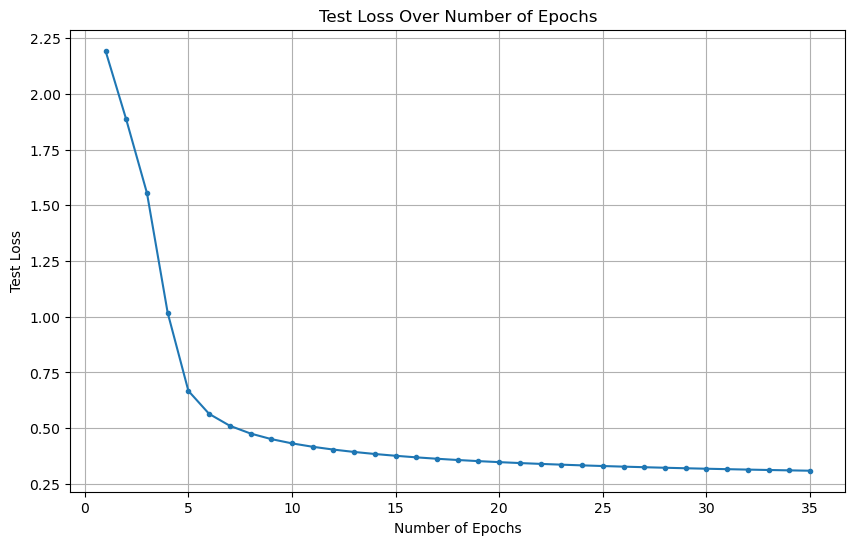

In [9]:
import matplotlib.pyplot as plt

# Define the test loss values and number of epochs
  # Replace with your data
num_epochs = list(range(1, len(loss) + 1))  # Assuming 1 to n epochs

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(num_epochs, loss, linestyle='-',marker = 'o',markersize = 3)
plt.title('Test Loss Over Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Test Loss')
plt.grid(True)
plt.savefig('/Users/zexuansun/Desktop/CS760/hw4pic/q4.2.png',dpi = 200)
# Display the plot
plt.show()


## Q4.3

In [14]:
import torch
from torch import nn
from torch.utils.data import DataLoader,Subset
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
#training_data = Subset(training_data, torch.arange(3000))
# train_dataloader = DataLoader(training_data, batch_size=64)
# test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_sig_stack = nn.Sequential(
            nn.Linear(28*28, 300,bias = False),
            nn.Sigmoid(),
            nn.Linear(300, 10,bias = False),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_sig_stack(x)
        return logits




# Initialize the loss function
# loss_fn = nn.CrossEntropyLoss()

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 1000 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss




# model = NeuralNetwork()
# for layer in model.modules():
#     if isinstance(layer, nn.Linear):
#          layer.weight.data.uniform_(-1,1)

# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)
loss_fn = nn.CrossEntropyLoss()

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")



Using cpu device


In [15]:
epochs = 100
n = 10
learning_rate = 1e-3
#train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)
res = torch.zeros(epochs)
loss = torch.zeros(epochs)
model = NeuralNetwork()



optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#train_data = Subset(training_data, torch.randint(len(training_data), size=(s[j],)))
train_dataloader = DataLoader(training_data,batch_size = 64)
for t in range(epochs):
    print('epochs',t)

    #print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    
    acc,tloss = test_loop(test_dataloader, model, loss_fn)
    res[t] = acc
    loss[t] = tloss
print("Done!")

epochs 0
Test Error: 
 Accuracy: 25.2%, Avg loss: 2.275498 

epochs 1
Test Error: 
 Accuracy: 35.8%, Avg loss: 2.245694 

epochs 2
Test Error: 
 Accuracy: 43.6%, Avg loss: 2.214171 

epochs 3
Test Error: 
 Accuracy: 50.0%, Avg loss: 2.179918 

epochs 4
Test Error: 
 Accuracy: 55.5%, Avg loss: 2.142026 

epochs 5
Test Error: 
 Accuracy: 59.4%, Avg loss: 2.099730 

epochs 6
Test Error: 
 Accuracy: 62.2%, Avg loss: 2.052472 

epochs 7
Test Error: 
 Accuracy: 63.9%, Avg loss: 1.999978 

epochs 8
Test Error: 
 Accuracy: 65.4%, Avg loss: 1.942319 

epochs 9
Test Error: 
 Accuracy: 66.8%, Avg loss: 1.879942 

epochs 10
Test Error: 
 Accuracy: 68.0%, Avg loss: 1.813647 

epochs 11
Test Error: 
 Accuracy: 69.4%, Avg loss: 1.744503 

epochs 12
Test Error: 
 Accuracy: 70.5%, Avg loss: 1.673734 

epochs 13
Test Error: 
 Accuracy: 71.7%, Avg loss: 1.602599 

epochs 14
Test Error: 
 Accuracy: 73.0%, Avg loss: 1.532280 

epochs 15
Test Error: 
 Accuracy: 74.0%, Avg loss: 1.463800 

epochs 16
Test Err

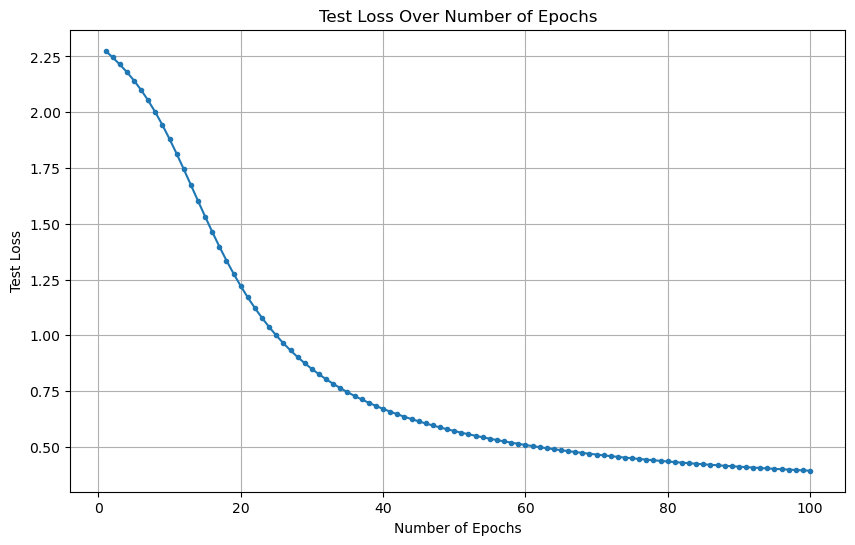

In [16]:
num_epochs = list(range(1, len(loss) + 1))  # Assuming 1 to n epochs

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(num_epochs, loss, linestyle='-',marker = 'o',markersize = 3)
plt.title('Test Loss Over Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Test Loss')
plt.grid(True)
plt.savefig('/Users/zexuansun/Desktop/CS760/hw4pic/q4.3.png',dpi = 200)
# Display the plot
plt.show()

## Q4.4

In [17]:
epochs = 100
n = 10
learning_rate = 1e-3
#train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)
res = torch.zeros(epochs)
loss = torch.zeros(epochs)
model = NeuralNetwork()


for layer in model.modules():
    if isinstance(layer, nn.Linear):
        layer.weight.data.zero_()
model = model.to(device=device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#train_data = Subset(training_data, torch.randint(len(training_data), size=(s[j],)))
train_dataloader = DataLoader(training_data,batch_size = 64)
for t in range(epochs):
    print('epochs',t)

    #print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    
    acc,tloss = test_loop(test_dataloader, model, loss_fn)
    res[t] = acc
    loss[t] = tloss
print("Done!")

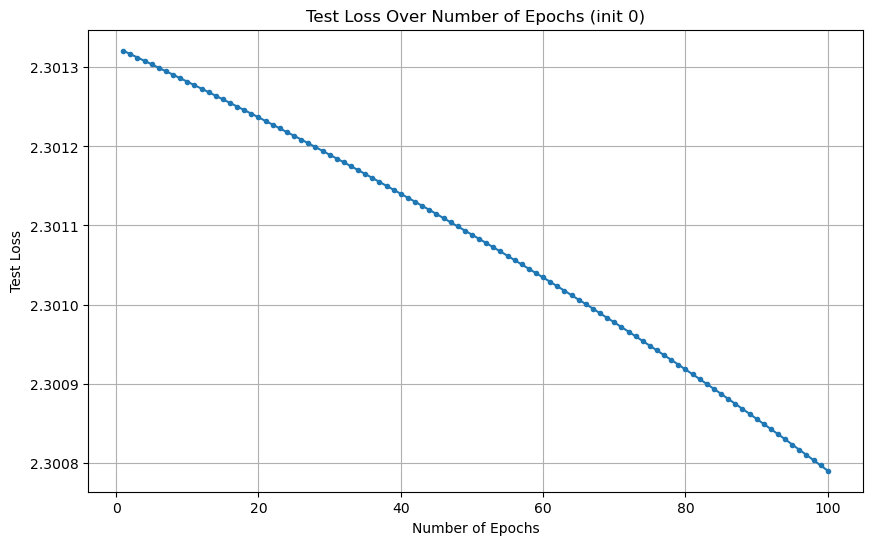

In [ ]:
num_epochs = list(range(1, len(loss) + 1))  # Assuming 1 to n epochs

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(num_epochs, loss, linestyle='-',marker = 'o',markersize = 3)
plt.title('Test Loss Over Number of Epochs (init 0)')
plt.xlabel('Number of Epochs')
plt.ylabel('Test Loss')
plt.grid(True)
plt.savefig('/Users/zexuansun/Desktop/CS760/hw4pic/q4.41.png',dpi = 200)
# Display the plot
plt.show()

In [18]:
epochs = 100
n = 10
learning_rate = 1e-3
#train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)
res = torch.zeros(epochs)
loss = torch.zeros(epochs)
model = NeuralNetwork()


for layer in model.modules():
    if isinstance(layer, nn.Linear):
        layer.weight.data.uniform_(-1,1)
model = model.to(device=device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#train_data = Subset(training_data, torch.randint(len(training_data), size=(s[j],)))
train_dataloader = DataLoader(training_data,batch_size = 64)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    
    acc,tloss = test_loop(test_dataloader, model, loss_fn)
    res[t] = acc
    loss[t] = tloss
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 14.4%, Avg loss: 4.803019 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 25.8%, Avg loss: 3.545528 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 36.0%, Avg loss: 2.778388 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 44.2%, Avg loss: 2.291923 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 50.6%, Avg loss: 1.965640 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 55.2%, Avg loss: 1.735362 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 58.5%, Avg loss: 1.565377 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 61.5%, Avg loss: 1.434997 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 63.7%, Avg loss: 1.331778 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 65.7%, Avg loss: 1.247917 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 67.5%, Avg los

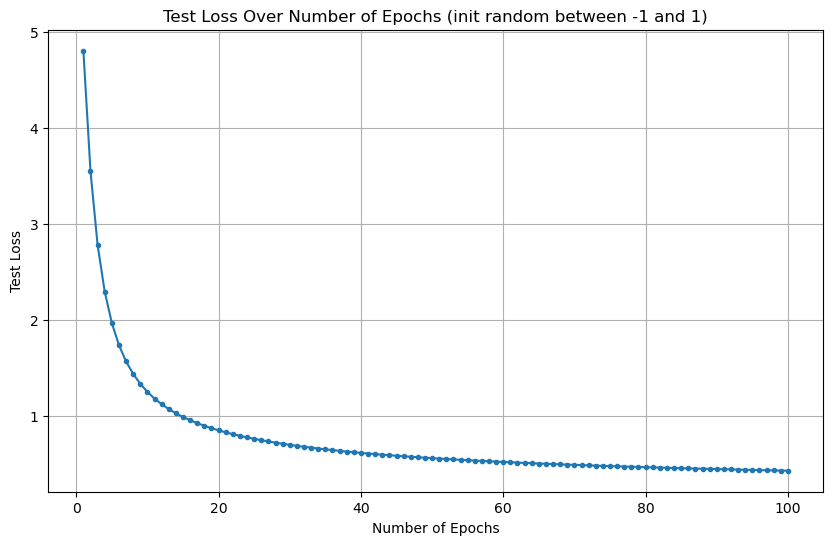

In [20]:
import matplotlib.pyplot as plt

# Define the test loss values and number of epochs
  # Replace with your data
num_epochs = list(range(1, len(loss) + 1))  # Assuming 1 to n epochs

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(num_epochs, loss, linestyle='-',marker = 'o',markersize = 3)
plt.title('Test Loss Over Number of Epochs (init random between -1 and 1)')
plt.xlabel('Number of Epochs')
plt.ylabel('Test Loss')
plt.grid(True)
plt.savefig('/Users/zexuansun/Desktop/CS760/hw4pic/q4.42.png',dpi = 200)
# Display the plot
plt.show()
